# Scikit Learn

This module focuses on the machine learning work hourse of Python: scikit-learn (also called sklearn). Scikit-learn is not part of the SciPy ecosystem but is built on top of several of it's major players including numpy, scipy, and matplotlib. If you're in need of any of the common machine learning methodologies or utilities you will probably find them here. The things you will not find are cutting edge and/or niche models and tools. Most notably, most requirements for reinforcement learning or deep learning are not going to be found in sklearn.

To learn about the major components of scikit-learn, we will walk through a small project from beginning to end. Along the way there will be exercises highlighting common components of the workflow. Once complete, you will practice the entire workflow by completing another project on your own.

## The Machine Learning Workflow

The basic workflow of machine learning often involves these steps:
1. Exploration: Getting acquinted with the data attributes, values, and problem(s).
2. Pre Processing: Transforming the original dataset to better suit your project's needs.
3. Data Subsetting: Splitting the dataset into training, test, and possibly other subsets.
4. Model Selection: Constraining the set of models to train on.
5. Model Training: Learning from the dataset to tune model parameters.
6. Model Analysis: Evaluating and picking the best model and parameters.

The workflow is often not sequential, and depending on the data and context different steps will take varying amounts of effort to complete. However, all of the steps are usually present in some form.

## The Iris dataset

For our tutorial project, we will use the [iris data set](https://scikit-learn.org/stable/datasets/index.html#iris-dataset). The cell below loads the dataset for you. 

In [42]:
import numpy as np
import pandas as pd
from sklearn import datasets
iris = datasets.load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Exploration

Your first step will be to explore the dataset using the previous modules tools. Since we've looked at this dataset in previous modules, you can jump ahead once you're comfortable. 
#### Exercise:
Make sure you can answer the following questions:

1. How many records are there?
2. How many attributes does each record have?
3. What is the meaning and datatype of each attribute?
3. What is the target attribute for prediction?
4. How many unique values are present for each attribute?
5. For attributes with low unique counts, what are the possible values and how frequent is each?
6. For quantiative attributes, plot their distribution and common statistics (mean, quartiles, etc.).
7. Do any attributes correlate highly with the target?

### Pre Processing

This dataset is already fairly clean. Some of the things to usually check for include:
* Missing values
* Drastically different numerical ranges
* Categorical variables

Run the following script to prove to yourself that this dataset is fairly clean.

In [43]:
nulls = iris_df.isnull().sum().rename('null_count')
mins = iris_df.min().rename('min')
maxs = iris_df.max().rename('max')
pd.concat([nulls, mins, maxs], axis=1)

,null_count,min,max
sepal length (cm),0,4.3,7.9
sepal width (cm),0,2.0,4.4
petal length (cm),0,1.0,6.9
petal width (cm),0,0.1,2.5
species,0,0.0,2.0


The one column that could be slightly cleaned up is the class column. Since this column represents 1 of 3 species of iris, it should probably be changed to a categorical data type. (*Note:* the impact of this will only be the pandas dataframe; often sklearn is happy to work with categorical targets as ints.)

In [44]:
print(f'Original type: {iris_df.species.dtypes}')
iris_df.loc[:,'species'] = pd.Categorical(iris_df.species)
print(f'Corrected type: {iris_df.species.dtypes}')

Original type: int64
Corrected type: category


### Data Subsetting

Once the data is processed, it's time to separate it into training and testing datasets (optionally other datasets). The point of this split is primarily to hold out data for validation. Because many models have the capability to overtrain (i.e. fit anomalies within the sample used for training), its possible they will assume that anomaly is consistent with the general population. Therefore, a testing dataset is used to verify overtraining has not occured and your model is still generalizable. Occasionally, intermediary holdouts are also useful to help direct hyper parameter tuning or model selection.

Scikit-learn provides several helpful methods for splitting the original dataset into training and testing sets. The cell below shows you how.

In [104]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, shuffle=False)

def show_split(x_train, x_test, y_train, y_test, n_samples):
    print(f'train shapes: {x_train.shape} and {y_train.shape}; {len(y_train)/n_samples:.2f} % of total')
    print(f' test shapes: {x_test.shape} and {y_test.shape}; {len(y_test)/n_samples:.2f} % of total')
    print(f'first 20 training targets: {y_train[:20]}')
    print(f'first 20  testing targets: {y_test[:20]}')
show_split(x_train, x_test, y_train, y_test, len(iris.target))

train shapes: (112, 4) and (112,); 0.75 % of total
 test shapes: (38, 4) and (38,); 0.25 % of total
first 20 training targets: [0 0 2 1 1 0 0 1 2 2 1 2 1 2 1 0 2 1 0 0]
first 20  testing targets: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2]


Carrying out the split is fairly easy; however, be careful of the parameters you choose. Because I incorrectly chose to not shuffle before splitting, the test set consists of only one species which happens to also be only minimally present in the training set. This is one of the reasons why it's usually better to take the default and shuffle before splitting.

#### Exercise 
Fix my mistake by resplitting the dataset. This time, ensure it shuffles beforehand, set the random seed to 42, and make the test set 30% of the original dataset. The documentation (or `help(train_test_split)`) may prove helpful.

In [62]:
x_train, x_test, y_train, y_test = (None, None, None, None) # insert your call here

### Model Selection

This is one of the steps in machine learning that is often an artform. Most practitioners are able to limit the number of models but cannot say up front what the best model will be. Even exports are usually incorrect at the beginning of the process. However, for models and datasets where there's no issues retraining you don't need to be correct right out of the gate. Instead, pick a subset that is as small as you can reasonably limit the choices, and experiment! For performing the initial limitation, you'll want to know:

1. What kind of problem am I trying to solve? (Regression, Classification, etc.)
2. What kind of attributes are involved? (Discrete, Continuous, Image, Text, etc.)
3. How many datapoints are there? (<100, <10K, <1M, etc.)

These criteria will usually limit a lot of your choices. For those not familiar with the models, there are many flow charts available for guiding this process. Scikit learn has published a [flow chart](https://scikit-learn.org/stable/tutorial/machine_learning_map/) that specifically links to estimators implemented in the library.

![Model Selection FlowChart for Scikit-Learn](flowchart.jpg)

#### Exercise:
Use the flowchart to decide on which models might be appropriate for the iris dataset (Hint: There should be 4 options)

### Model Training

Now that we've selected a model, it's time to start training. This is the meat and potatoes of scikit learn. Every model in scikit-learn implements the [estimator](https://scikit-learn.org/stable/glossary.html#term-estimator) interface. An estimator exposes the `fit` method which expects the training dataset to be passed in, and methods for getting and setting parameters of the model. Estimator's used for prediction also expose a `predict` method, which can be passed the train, test (or future) datasets to gauge performance.

As an example, let's use the Linear SVC Estimator.

In [105]:
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
model = LinearSVC(C=1.0, max_iter=10000)
model.fit(x_train, y_train)
y_pred = model.predict(x_train)

With the prediction on the training set in hand, we can assess how well we did both visuallly and numerically.

Accuracy: 0.9732142857142857


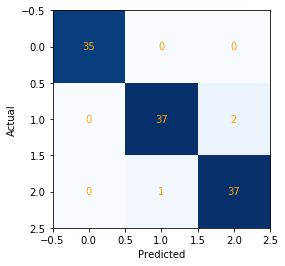

In [106]:
from sklearn.metrics import accuracy_score, confusion_matrix

def show_metrics(y_train, y_pred):
    print(f'Accuracy: {accuracy_score(y_train, y_pred)}')
    fig, ax = plt.subplots()
    confusion = confusion_matrix(y_train, y_pred)
    ax.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            ax.text(j, i, confusion[i, j], ha='center', va='center', color='orange')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
show_metrics(y_train, y_pred)

#### Exercise:

First choice was fairly accurate. But depending on the domain, 97% accuracy might not be good enough. Can we do better? Choose one of the three other models discussed in the Model Selection step and try fitting it.

Accuracy: 0.9553571428571429


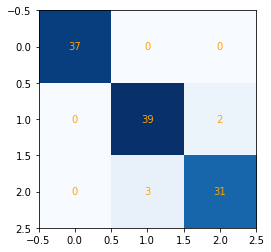

In [100]:
# import your model constructor,
# construct your model,
# fit it, 
# and assign your new predictions to y_pred2
show_metrics(y_train, y_pred2)

### Model Analysis

Now that the model is tuned and we think it's trained sufficiently, it's time to determine how well we did. The process was started in the previous section, but there are still several outstanding questions to analyze:

* Did we choose the best model?
* For each model, did we choose the best set of hyper parameters?
* How did the selected model perform on the test set?

For all of these questions, a metric is needed to assess performance. Metrics in scikit-learn are generally specified in one of three ways:
1. Many estimators expose a `score` method, which can be used to specify a default metric.
2. Tools using cross-validation have a `scoring` parameter used for internal model evaluation.
3. The metrics module contains functions that can be used for additional evaluation. Each of them expect at least two args, the true and predicted target values.

#### Exercise 
We've used accuracy and shown the confusion matrix above, but this is not the only set of metrics that might make sense. Look through the metrics module [documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) and see if you can find another metric worth evaluating for this problem. Compute it for all of the models we've trained so far



In [102]:
# compute your metrics here, for both y_pred and y_pred2

Now that we have metrics chosen, let's return to the unanswered questions. The first two questions both need our metric to be measured on more than the training set. Otherwise, we will not know if the model and hyper-parameters generalize well. So let's measure the metrics on our test set.

Accuracy: 1.0


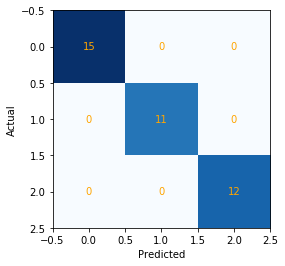

In [107]:
show_metrics(y_test, model.predict(x_test))

Surprisingly, the test set has performed even better! We should note that with only 38 points in the test set, 1 point corresponds to a 2.6% shift. So really our accuracy should have *at least* a $\pm1.3%$ uncertainty appended to it.

Now, we could repeat this procedure for several sets of hyper parameters and several models and choose the best. By doing so we will lose the ability to use the test set performance as a measure of how well the model generalizes. Instead, these results can only be used to measure how well the trained parameters generalize within the model. This problem is one reason why intermediary test sets are separated out. Due to time constraints we will not investigate this problem. If you're interested in learning more, I'd recommend looking into cross-validation techniques. 

## The Final Project

Now that we've gone through one complete project, it's time to do your own. Choose one of the below toy datasets available through scikit-learn to work on in a group:

* [Wine Quality](https://scikit-learn.org/stable/datasets/index.html#wine-dataset)
* [Diabetes Progression](https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset)
* [Handwritten Digits](https://scikit-learn.org/stable/datasets/index.html#digits-dataset)

Create a separate notebook to work in and step through each of the steps outlined above. Once time is up, each group will give a short five minute presentation showing what discoveries they made. The Jupyter notebook will be your presentation material, so document well.